In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ogle_utils as ou
import matplotlib.colors as colors
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import microlensing_calculations

In [4]:
ogle_dat = pd.read_csv('data/ogleiv_bulgerates.txt', skiprows=26, sep='\s+',
              names=['field','GLON','GLAT','tau','e_tau','gam','e_gam','gam_deg2','e_gam_deg2',
                     'tE_mean','e_tE_mean','Nevents','Nstars']).set_index('field')
ogle_flds = pd.read_csv('data/ogleiv_bulgefields.txt', skiprows=19, sep='\s+',
              names=['field','RAdeg','DEdeg','GLON','GLAT','Nstars','Nepochs']).set_index('field')
ogle_subfs = pd.read_csv('data/ogleiv_subfields.txt', skiprows=22, sep='\s+',
              names=['field','RAdeg','DEdeg','GLON','GLAT','Sigma18','Sigma21','N18','N21']).set_index('field')
#inmap.set_index('field', inplace=True)
#ogle_dat.set_index('field', inplace=True)
#ogle_subfs.set_index('field', inplace=True)
ogle_dat.insert(2,column='RAdeg',value=ogle_flds['RAdeg'])
ogle_dat.insert(3,column='DEdeg',value=ogle_flds['DEdeg'])
ogle_dat.sort_values('GLAT',inplace=True)
inmap = ogle_dat[(np.abs(ogle_dat['GLON'])<10) & (ogle_dat['GLAT']<5) & (ogle_dat['GLAT']>-10)]

l3 = ogle_dat[(np.abs(ogle_dat['GLON'])<3) & (ogle_dat['Nevents']>1) & (np.abs(ogle_dat['GLAT'])>0.7)]

In [5]:
ogle_subfs[['GLON','GLAT']].to_csv('data/ogle_subf_coords.csv',index=False,header=False)

3842


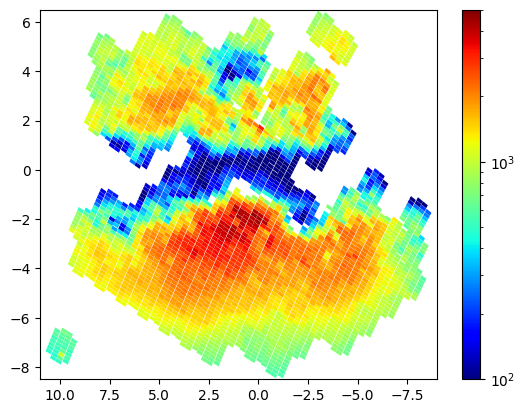

In [6]:
fig,ax=plt.subplots()
patches=[]
sf_cols = []
for lrow in np.transpose([ogle_dat.index,ogle_dat['RAdeg'],ogle_dat['DEdeg']]):
    f,ra,dec=lrow
    for j in range(1,33):
        sbf_name = f+'.'+str(j).zfill(2)
        p = Polygon(np.column_stack(ou.equatorial_to_galactic(*ou.o4_subfield(ra,dec,j))),closed=True)
        try:
            dat = ogle_subfs.at[sbf_name, 'Sigma21']
            patches.append(p)
            sf_cols.append(dat)
        except:
            pass
#print(sf_cols)
norm = colors.LogNorm(vmin=100, vmax=5000)
pc = PatchCollection(patches, cmap='jet', norm=norm)
pc.set_array(sf_cols)
pc.set_edgecolor('none')
ax.add_collection(pc)

cbar = plt.colorbar(pc)

plt.xlim(11,-9)
plt.ylim(-8.5,6.5)
print(len(sf_cols))

121


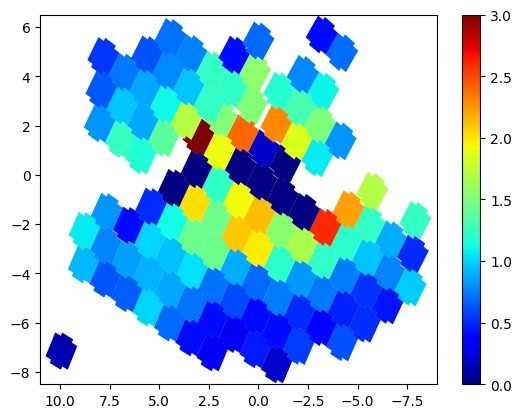

In [7]:
fig,ax=plt.subplots()
patches=[]
sf_cols = []
for lrow in np.transpose([ogle_dat.index,ogle_dat['RAdeg'],ogle_dat['DEdeg']]):
    f,ra,dec=lrow
    p = Polygon(np.column_stack(ou.equatorial_to_galactic(*ou.o4_field(ra,dec))),closed=True)
    patches.append(p)
    sf_cols.append(ogle_dat.at[f,'tau'])
#print(sf_cols)
norm = colors.Normalize(vmin=0, vmax=3)
pc = PatchCollection(patches, cmap='jet', norm=norm)
pc.set_array(sf_cols)
pc.set_edgecolor('none')
ax.add_collection(pc)

cbar = plt.colorbar(pc)

plt.xlim(11,-9)
plt.ylim(-8.5,6.5)
print(len(sf_cols))

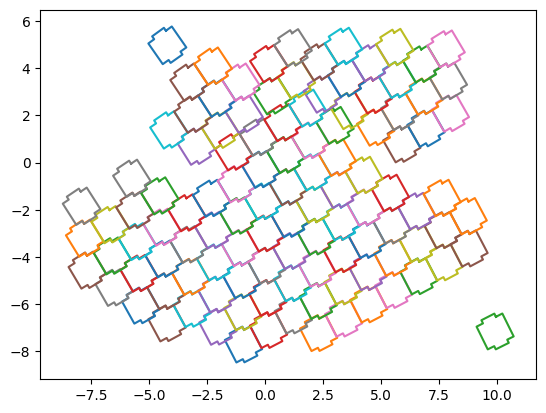

In [8]:
for i,lb in enumerate(np.transpose([inmap['RAdeg'],inmap['DEdeg']])):
    l,b=lb
    ls,bs = ou.equatorial_to_galactic(*ou.o4_field(l,b))
    ls = np.append(ls,[ls[0]])
    bs = np.append(bs,[bs[0]])
    plt.plot(ls,bs)

In [9]:
pts0 = [[ 0.9999, -1.0293],[-0.0608, -1.64  ],[ 2.1491, -1.7747],[ 1.087 , -2.389 ],
       [ 0.0103, -2.9974],[-1.0641, -3.6101],[-2.1341, -4.2222],[ 2.2154, -3.1355],
       [ 1.1399, -3.7432],[ 0.0747, -4.3626],[-0.9993, -4.9741],[-2.0711, -5.587 ],
       [ 2.2603, -4.4933],[ 1.1905, -5.1086],[ 2.2975, -5.8574],[ 1.226 , -6.4752],
       [-1.1356, -2.2547],[-2.2129, -2.8632],[ 0.153 , -7.0928],[-0.9252, -7.7037],
       [ 0.1216, -5.7276],[-0.9534, -6.3377],[-2.028 , -6.951 ],[ 0.3282,  2.8242],
       [-1.0464,  3.4008],[-2.0762,  2.7248],[-2.2382,  4.0765],[ 0.0082,  5.4341],
       [ 1.9634,  0.9419],[ 1.8508,  2.3   ],[-0.8998,  2.0442],[-1.9286,  1.3682],
       [ 2.3179, -7.2216],[ 0.1737,  4.1858],[ 1.3523,  3.4996],[ 0.7819,  1.6875],
       [ 2.4794,  2.8944],[ 2.3472,  4.2575]]
pd_pts = pd.DataFrame(pts0,columns=['l','b']).sort_values('b')
pts=np.array(pd_pts)

In [10]:
import synthpop as sp
sp_lens = sp.SynthPop(default_config='macy_defaults.synthpop_conf',
                      model_name="Huston2024", name_for_output='lens',
                     maglim=['Bessell_I', 21,"keep"], output_location="outputfiles/ogle",
                     extinction_map_kwargs={"name":"surot","project_3d":False,"dist_2d":2.0})
sp_src  = sp.SynthPop(default_config='macy_defaults.synthpop_conf',
                      model_name="Huston2024", name_for_output='src',
                     maglim=['Bessell_I', 21,"remove"], output_location="outputfiles/ogle",
                     extinction_map_kwargs={"name":"surot","project_3d":False,"dist_2d":2.0})
sp_lens.init_populations()
sp_src.init_populations()

Execution Date: 03-03-2025 16:12:15


################################ Settings #################################
# reading default parameters from
default_config_file =  /Users/mhuston/Documents/synthpop/synthpop/config_files/macy_defaults.synthpop_conf 


# copy the following to a config file to redo this model generation -------
{
    "l_set": null,
    "l_set_type": null,
    "b_set": null,
    "b_set_type": null,
    "random_seed": 363532242,
    "name_for_output": "lens",
    "model_name": "Huston2024",
    "solid_angle": 0.0001,
    "solid_angle_unit": "deg^2",
    "sun": {
        "x": -8.178,
        "y": 0.0,
        "z": 0.017,
        "u": 12.9,
        "v": 245.6,
        "w": 7.78,
        "l_apex_deg": 56.24,
        "b_apex_deg": 22.54
    },
    "lsr": {
        "u_lsr": 1.8,
        "v_lsr": 233.4,
        "w_lsr": 0.53
    },
    "warp": {
        "r_warp": 7.72,
        "amp_warp": 0.06,
        "amp_warp_pos": null,
        "amp_warp_neg": null,
        "alpha_warp

KeyboardInterrupt: 

In [ ]:
ulim = 20000
llim = 8000
alim = 12000
solang = 1e-5
for pt in pts:
    l,b=pt
    df1,_ = sp_lens.process_location(l_deg=l, b_deg=b, solid_angle=solang)
    leng = len(np.array(df1['W146']))
    if leng>ulim or leng<llim:
        print('    length:',leng,", rerunning l=",l,' b=',b)
        solang = solang * alim/leng
        df1,_ = sp_lens.process_location(l_deg=l, b_deg=b, solid_angle=solang)
        leng = len(np.array(df1['W146']))
    solang = solang * alim/leng

In [ ]:
for pt in pts:
    l,b=pt
    df1,_ = sp_src.process_location(l_deg=l, b_deg=b, solid_angle=solang)
    leng = len(np.array(df1['W146']))
    if leng>ulim or leng<llim:
        print('    length:',leng,", rerunning l=",l,' b=',b)
        solang = solang * alim/leng
        df1,_ = sp_src.process_location(l_deg=l, b_deg=b, solid_angle=solang)
        leng = len(np.array(df1['W146']))
    solang = solang * alim/leng

In [11]:
output_cols = ['l','b','n_source','n_lens','sa_source','sa_lens',
                  'avg_tau','avg_t','avg_theta',
                  'eventrate_area','eventrate_source',
                  'avg_ds','avg_dl',
                  'stdev_ds','stdev_dl','stdev_t',
                  'frac_bulge_lens', 'frac_disk_lens','frac_bulge_source','frac_disk_source']
len_dir = 'outputfiles/ogle/lens_'     #directory that the source and lens catalogs are in
src_dir = 'outputfiles/ogle/src_'      #directory that the source and lens catalogs are in
data_list = []
for pt in pts:
    l,b=pt
    dat,_ = microlensing_calculations.mulens_stats(len_dir,src_dir, l,b, outputs=output_cols)
    data_list.append(dat)
    print(*dat)
output = pd.DataFrame(data=data_list, columns=output_cols)
output.to_csv('mulens_rates_ogle_pit.txt', index=False)

KeyboardInterrupt: 

In [12]:
#sp_dat = pd.read_csv('mulens_stats_I21_bdep.txt')
sp_dat = pd.read_csv('mulens_rates_ogle_pit.txt')
sp_dat.keys()

Index(['l', 'b', 'n_source', 'n_lens', 'sa_source', 'sa_lens', 'avg_tau',
       'avg_t', 'avg_theta', 'eventrate_area', 'eventrate_source', 'avg_ds',
       'avg_dl', 'stdev_ds', 'stdev_dl', 'stdev_t', 'frac_bulge_lens',
       'frac_disk_lens', 'frac_bulge_source', 'frac_disk_source'],
      dtype='object')

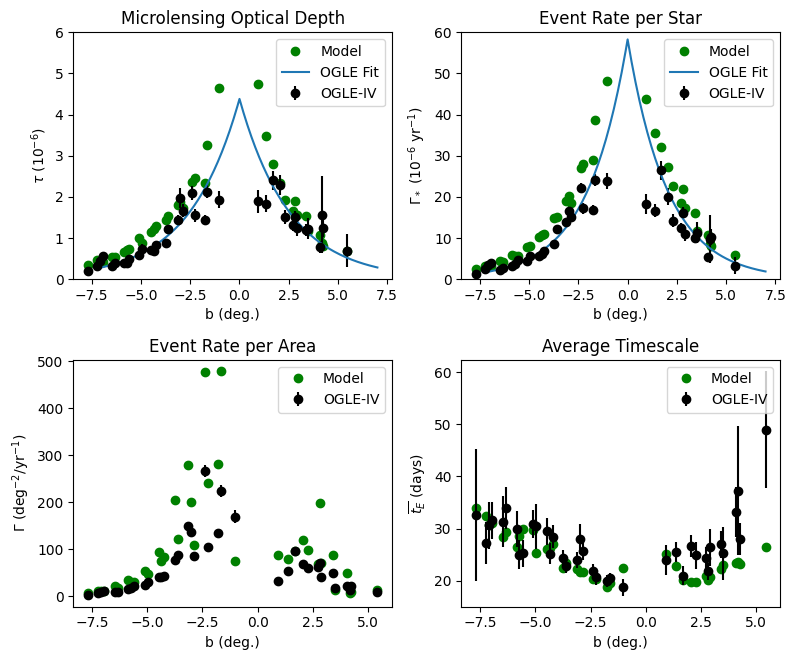

In [15]:
b_pts = np.arange(-7,7.0001,0.1)
def tau_fit(b):
    return 1.36 * np.exp(0.39*(3-abs(b)))
def rt_fit(b):
    return 13.4 * np.exp(0.49*(3-abs(b)))

modlab='Model'; oglab='OGLE-IV'

plt.subplots(nrows=2,ncols=2,figsize=(8,6.7))
plt.subplot(221)
plt.title('Microlensing Optical Depth')
plt.plot(sp_dat['b'], sp_dat['avg_tau']*10**6,'go',label=modlab)
plt.errorbar(l3['GLAT'],l3['tau'], yerr=l3['e_tau'],linestyle='none',marker='o',c='k',label=oglab)
plt.plot(b_pts, tau_fit(b_pts),label='OGLE Fit')
plt.ylabel(r'$\tau$ (10$^{-6}$)'); plt.xlabel('b (deg.)')
plt.ylim(0,6)
plt.legend()

plt.subplot(222)
plt.title('Event Rate per Star')
plt.plot(sp_dat['b'], sp_dat['eventrate_source']*10**6,'go',label=modlab)
plt.errorbar(l3['GLAT'],l3['gam'], yerr=l3['e_gam'],linestyle='none',marker='o',c='k',label=oglab)
plt.plot(b_pts, rt_fit(b_pts),label='OGLE Fit')
plt.ylabel(r'$\Gamma_*$ (10$^{-6}$ yr$^{-1}$)'); plt.xlabel('b (deg.)')
plt.ylim(0,60)
plt.legend()

plt.subplot(223)
plt.title('Event Rate per Area')
plt.plot(sp_dat['b'], sp_dat['eventrate_area'],'go',label=modlab)
plt.errorbar(l3['GLAT'],l3['gam_deg2'], yerr=l3['e_gam_deg2'],linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel(r'$\Gamma$ (deg$^{-2}$/yr$^{-1}$)'); plt.xlabel('b (deg.)')
#plt.ylim(0,60)
plt.legend()

plt.subplot(224)
plt.title('Average Timescale')
plt.plot(sp_dat['b'], sp_dat['avg_t'],'go',label=modlab)
plt.errorbar(l3['GLAT'],l3['tE_mean'], yerr=l3['e_tE_mean'],linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel('$\overline{t_E}$ (days)'); plt.xlabel('b (deg.)')
#plt.ylim(0,60)
plt.tight_layout()
plt.legend()

plt.savefig('figures/ogle_bdep_pit.png')

In [ ]:
b_pts = np.arange(-7,7.0001,0.1)
def tau_fit(b):
    return 1.36 * np.exp(0.39*(3-abs(b)))
def rt_fit(b):
    return 13.4 * np.exp(0.49*(3-abs(b)))

modlab='Model'; oglab=None

plt.subplots(nrows=2,ncols=2,figsize=(12,10))
plt.subplot(221)
plt.title('Microlensing Optical Depth')
plt.errorbar(sp_dat['b'], np.array(sp_dat['avg_tau'])*10**6/np.array(l3['tau']), 
             yerr=l3['e_tau']/l3['tau']**2*np.array(sp_dat['avg_tau'])*10**6,
             linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel(r'$\tau_{model}/\tau_{OGLE}$'); plt.xlabel('b (deg.)')
plt.axhline(1, color='gray',linestyle='--')
#plt.ylim(0,6)
#plt.legend()

plt.subplot(222)
plt.title('Event Rate per Star')
plt.errorbar(l3['GLAT'],np.array(sp_dat['eventrate_source'])*10**6/np.array(l3['gam']), 
             yerr=l3['e_gam']*np.array(sp_dat['eventrate_source'])*10**6/np.array(l3['gam'])**2,
             linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel(r'$\Gamma_{*, model}/\Gamma_{*, OGLE}$'); plt.xlabel('b (deg.)')
plt.axhline(1, color='gray',linestyle='--')
#plt.legend()

plt.subplot(223)
plt.title('Event Rate per Area')
plt.errorbar(l3['GLAT'],np.array(sp_dat['eventrate_area'])/l3['gam_deg2'], 
             yerr=l3['e_gam_deg2']*np.array(sp_dat['eventrate_area'])/l3['gam_deg2']**2,
             linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel(r'$\Gamma_{model}/\Gamma_{OGLE}$'); plt.xlabel('b (deg.)')
plt.axhline(1, color='gray',linestyle='--')
#plt.ylim(0,60)
#plt.legend()

plt.subplot(224)
plt.title('Average Timescale')
plt.errorbar(l3['GLAT'],np.array(sp_dat['avg_t'])/l3['tE_mean'], 
             yerr=l3['e_tE_mean']*np.array(sp_dat['avg_t'])/l3['tE_mean']**2,
             linestyle='none',marker='o',c='k',label=oglab)
plt.ylabel('$\overline{t_E}_{, model}/\overline{t_E}_{, OGLE}$'); plt.xlabel('b (deg.)')
plt.axhline(1, color='gray',linestyle='--')
#plt.ylim(0,60)
#plt.legend()

plt.savefig('figures/ogle_bdep_ratio_pit.png')